# Cafe Rewards Program: Interaction Patterns and Completion Rates

### Introduction and Background

I conducted this analysis in response to a request from the marketing team, seeking insights into customer interactions with various reward offers. Below is the original email detailing the specific objectives and requirements for the analysis:

<img src="images/request_email.jpg" alt="analysis-request-email" width="40%">

### Data Dictionary

#### 1. `offers` Table  
Contains details about each offer available to customers:  
- **offer_id**: A unique code for each offer.  
- **offer_type**: The type of offer:  
  - **BOGO**: Buy one, get one free.  
  - **Discount**: Money off on purchases.  
  - **Informational**: No reward, just information on products.  
- **difficulty**: Minimum amount a customer must spend to qualify for the reward.  
- **reward**: Dollar amount a customer earns for completing the offer (only for BOGO and Discount offers).  
- **duration**: The number of days the customer has to complete the offer after receiving it.  
- **channels**: Methods used to send the offer to customers (e.g., email, social media).  

#### 2. `customers` Table  
Information about each customer in the rewards program:  
- **customer_id**: A unique identifier for each customer.  
- **became_member_on**: The date the customer joined the rewards program.  
- **gender**: The customer’s gender (Male, Female, Other).  
- **age**: The customer’s age.  
- **income**: The customer’s estimated annual income (in USD).  

#### 3. `events` Table  
Tracks customer actions over a 30-day period, including transactions and interactions with offers:  
- **customer_id**: Links this record to a specific customer.  
- **event**: Describes what happened, with possible types:  
  - **Transaction**: The customer made a purchase.  
  - **Offer received**: The customer got an offer.  
  - **Offer viewed**: The customer looked at an offer.  
  - **Offer completed**: The customer met the conditions of the offer and earned the reward.  
- **value**: Contains specific details for each event:  
  - For **transaction** events: The amount spent.  
  - For **offer-related** events (received, viewed, completed): The `offer_id`.  
  - For **offer completed** events: The `offer_id` is appended with the word "reward".
- **time**: The number of hours since the start of the 30-day period when the event occurred.  


### How It All Connects  

- **Offers and events**:  
  Each time a customer receives an offer, an "offer received" event appears in the `events` table.  
  - If the customer views the offer, it’s logged as "offer viewed."  
  - Completing the offer (meeting requirements and spending enough) generates an "offer completed" event with the reward earned.  

- **Transactions and offers**:  
  Transactions capture customer spending. If a transaction occurs while completing an offer, it can be **attributed** to that offer.

### Setup and Imports
I'm using the following libraries:
- `pandas`: For data manipulation and analysis.
- `seaborn` and `matplotlib.pyplot`: For visualizations.
- `ast`: For evaluating and parsing string representations of Python literals (in this example dictionaries) into actual Python objects.
- `time`: For tracking script run time.

In [ ]:
# Import the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import time

# Load the offers and customers data
offers = pd.read_csv("source-data/offers.csv")
customers = pd.read_csv("source-data/customers.csv")

# Load and combine the events data from the two parts (due to GitHub 25 MB size limit)
events_pt1 = pd.read_csv("source-data/events-pt1.csv")
events_pt2 = pd.read_csv("source-data/events-pt2.csv")
events = pd.concat([events_pt1, events_pt2], ignore_index=True)


### Data Cleaning & Merging  
This section handles the data cleaning and merging steps. First, I clean the "value" column in the `events` dataframe to standardize the keys by replacing spaces with underscores. Then, I define a function to extract the `offer_id` part from the "value" column, which contains dictionary-like strings. Additionally, I identify inactive customers (age 118), as there is no information about them in the `customers` dataset, and they did not interact with the received offers. After extracting the `offer_id`, I merge the `events`, `offers`, and `customers` dataframes. Finally, I map the `offer_id` to a human-readable `offer_name` using a dictionary.


In [3]:
# Step 1: Clean the 'value' column to standardize the keys
events['value'] = events['value'].apply(lambda x: x.replace('offer id', 'offer_id') if isinstance(x, str) else x)

# Function to extract offer_id from 'value' field (value is in a format resembling a dictionary)
def extract_offer_id(value):
    try:
        # Convert string representation of dict into an actual dictionary
        value_dict = ast.literal_eval(value)
        # Return the offer_id if present in the dictionary
        return value_dict.get('offer_id') if isinstance(value_dict, dict) else None
    except:
        # If the value cannot be parsed as a dictionary, return None
        return None

# Apply the function to extract offer_id from the 'value' column
events['offer_id'] = events['value'].apply(extract_offer_id)

# Step 2: Merge CSV files using 'offer_id' and 'customer_id'
merged_data = events.merge(offers, on='offer_id', how='left').merge(customers, on='customer_id', how='left')

# Step 3: Dictionary to map each offer_id to a detailed name
offer_names = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_2',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_3',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_4',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount_1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount_2',
    'fafdcd668e3743c1bb461111dcafc2a4': 'discount_3',
    '2906b810c7d4411798c6938adc9daaa5': 'discount_4',
    '3f207df678b143eea3cee63160fa8bed': 'informational_1',
    '5a8bc65990b245e5a138643cd4eb9837': 'informational_2'
}

# Map offer IDs to names in the merged_data DataFrame
merged_data['offer_name'] = merged_data['offer_id'].map(offer_names)

# Step 4: Identify inactive customers (age 118)
inactive_customers_count = customers[customers['age'] == 118].shape[0]
total_customers_count = customers.shape[0]
inactive_percentage = (inactive_customers_count / total_customers_count) * 100

print(f"Inactive customers (age 118): {inactive_customers_count}")
print(f"Percentage of inactive customers: {inactive_percentage:.2f}%")

# Step 5: Exclude inactive customers from the dataset
merged_data = merged_data[merged_data['age'] != 118]


Inactive customers (age 118): 2175
Percentage of inactive customers: 12.79%


### Calculation of Informational Offers Completions

In this step, I identify and exclude transactions that are either part of other offers or unrelated to any promotional efforts. I set up a 72-hour window in which a customer must view an informational offer and make a transaction (of any amount) for the offer to be considered completed. Only transactions that meet these criteria are included in the analysis.

- First, I exclude transactions that are immediately followed by an 'offer completed' event at the same time. This step ensures that transactions related to the completion of other offers are not counted.
- Next, I consider transactions that occur within the 72-hour window after a 'viewed' event for an informational offer. Only these transactions are included in the final list.
- I compile the filtered transactions into a list and convert it into a DataFrame for further analysis.


In [4]:
# Record the start time
start_time = time.time()

# Step 1: Sort merged_data by customer_id and time to ensure events are in sequence
merged_data_sorted = merged_data.sort_values(by=['customer_id', 'time']).reset_index(drop=True)

# Number of rows in the dataset
num_rows = len(merged_data_sorted)

# Initialize a set to store indices of transactions to exclude
excluded_transactions = set()

# Exclude transactions immediately followed by 'offer completed' at the exact same time
for idx, row in merged_data_sorted.iterrows():
    if row['event'] == 'transaction' and idx + 1 < len(merged_data_sorted):
        # Check the next row for an 'offer completed' event with the same customer_id and time
        next_row = merged_data_sorted.iloc[idx + 1]
        if next_row['event'] == 'offer completed' and next_row['customer_id'] == row['customer_id'] and next_row['time'] == row['time']:
            excluded_transactions.add(idx)

# Step 2: Include only relevant transactions for informational offers within a 72-hour cutoff
informational_completions = 0
cutoff_hours = 72  # 72-hour window

# Initialize a list to collect rows that qualify as informational completions
informational_completions_list = []

# List of offer IDs that are informational
informational_offer_ids = [key for key, value in offer_names.items() if "informational" in value]

for idx, row in merged_data_sorted.iterrows():
    if idx in excluded_transactions:
        continue

    # Check for 'offer viewed' event related to any informational offers
    if row['event'] == 'offer viewed' and row['offer_id'] in informational_offer_ids:
        view_time = row['time']
        customer_id = row['customer_id']
        offer_id = row['offer_id']  # Get the specific offer_id directly from the row

        # Find all transactions for the same customer within the 72-hour cutoff after this view
        qualifying_transactions = merged_data_sorted[
            (merged_data_sorted['customer_id'] == customer_id) &
            (merged_data_sorted['event'] == 'transaction') &
            (merged_data_sorted['time'] > view_time) &
            (merged_data_sorted['time'] <= view_time + cutoff_hours)
        ]

        # Append each qualifying transaction to the list, tagging it with the relevant offer_id
        for _, transaction_row in qualifying_transactions.iterrows():
            transaction_entry = transaction_row.copy()  # Copy the row to avoid changes to the original
            transaction_entry['offer_id'] = offer_id  # Assign the specific informational offer_id
            informational_completions_list.append(transaction_entry)

# Convert the list to a DataFrame
informational_completions_df = pd.DataFrame(informational_completions_list)

# Record the end time
end_time = time.time()

# Print the running stats
print(f"Run time: {(end_time - start_time)/60:.2f} minutes")
print(f"Number of rows processed: {num_rows}")

# Display the first three rows of informational_completions_df
print("Informational completions:")
informational_completions_df.head(3)


Run time: 7.09 minutes
Number of rows processed: 272762
Informational completions:


,customer_id,event,value,time,offer_id,offer_type,difficulty,reward,duration,channels,became_member_on,gender,age,income,offer_name
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN,NaN,20170421.0,M,33.0,72000.0,NaN
6,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,NaN,20170421.0,M,33.0,72000.0,NaN
55,0020c2b971eb4e9188eac86d93036a77,transaction,{'amount': 27.94},696,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN,NaN,20160304.0,F,29.0,90000.0,NaN


### Summing Up Interaction Counts by Offer Type

In this section, I create columns in the `customers` DataFrame to count each level of interaction (received, viewed, and completed) for each specific offer type. It's essential for understanding customer engagement across different offers and supporting demographic analyses of customer behavior.

- **Received**: Counts how many times each customer received an offer.
- **Viewed**: Counts how many times each customer viewed the offer, following up on the initial receipt.
- **Completed**: Counts offer completions. For informational offers, this is defined as a transaction occurring within a 72-hour window after viewing the offer. For all other offers, this refers to explicit "offer completed" events.

The process iterates through each offer type and populates these counts in the `customers` DataFrame:
1. **Initialize Columns**: First, I set up columns for each interaction level (`received`, `viewed`, `completed`) for all offer types in `offer_names`.
2. **Filter by Offer Type**: For each `offer_id`:
   - I filter the events data to focus only on this specific offer.
3. **Calculate Counts**:
   - **Received**: Counts 'offer received' events per customer.
   - **Viewed**: Counts 'offer viewed' events per customer.
   - **Completed (Informational Offers)**: For informational offers, I track completions based on transactions within 72 hours after viewing.
   - **Completed (Other Offers)**: For other offers, I count 'offer completed' events directly.
4. **Update Customers DataFrame**: Each count is then updated in the respective columns for the corresponding customers, allowing for easy aggregation, comparison, and demographic breakdowns.

In [5]:
# Record the start time
start_time = time.time()

# Number of rows in the dataset
num_rows = len(customers)

# Initialize columns in the customers DataFrame for each offer event (received, viewed, completed)
for offer_name in offer_names.values():
    customers[f"{offer_name}_received"] = 0
    customers[f"{offer_name}_viewed"] = 0
    customers[f"{offer_name}_completed"] = 0

# Iterate over each offer type and populate counts in the customers DataFrame
for offer_id, offer_name in offer_names.items():
    # Filter events for this specific offer_id
    offer_events = merged_data[merged_data['offer_id'] == offer_id]

    # Count 'received' events for each customer and update in customers DataFrame
    received_counts = offer_events[offer_events['event'] == 'offer received']['customer_id'].value_counts()
    for customer_id, count in received_counts.items():
        customers.loc[customers['customer_id'] == customer_id, f"{offer_name}_received"] += count

    # Count 'viewed' events for each customer and update in customers DataFrame
    viewed_counts = offer_events[offer_events['event'] == 'offer viewed']['customer_id'].value_counts()
    for customer_id, count in viewed_counts.items():
        customers.loc[customers['customer_id'] == customer_id, f"{offer_name}_viewed"] += count

    # For informational offers, count transactions that happened within 72 hours of the offer view
    if 'informational' in offer_name:
        # Get the informational offer_id
        informational_completions = informational_completions_df[informational_completions_df['offer_id'] == offer_id]
        
        # Count the number of completed transactions for each customer related to this informational offer
        completed_counts = informational_completions['customer_id'].value_counts()
        for customer_id, count in completed_counts.items():
            customers.loc[customers['customer_id'] == customer_id, f"{offer_name}_completed"] += count

    # Count 'completed' events for each customer and update in customers DataFrame (for non-informational offers)
    if 'informational' not in offer_name:
        completed_counts = offer_events[offer_events['event'] == 'offer completed']['customer_id'].value_counts()
        for customer_id, count in completed_counts.items():
            customers.loc[customers['customer_id'] == customer_id, f"{offer_name}_completed"] += count

# Record the end time
end_time = time.time()

# Print the running stats
print(f"Run time: {(end_time - start_time)/60:.2f} minutes")
print(f"Number of rows processed: {num_rows}")

# Display the first three rows of the "customers" dataframe
print("'Customers' dataframe:")
customers.head(3)


Run time: 4.53 minutes
Number of rows processed: 17000
'Customers' dataframe:


,customer_id,became_member_on,gender,age,income,bogo_1_received,bogo_1_viewed,bogo_1_completed,bogo_2_received,bogo_2_viewed,...,discount_3_completed,discount_4_received,discount_4_viewed,discount_4_completed,informational_1_received,informational_1_viewed,informational_1_completed,informational_2_received,informational_2_viewed,informational_2_completed
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,118,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,20170715,F,25,112000.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,118,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Summing Up Offer Interactions and Calculating Completion Rates

In this part I summarize interactions with each offer type by detailing the number of times each offer was `received`, `viewed`, and `completed`, and calculating the completion rate for each offer. This summary helps analyze the effectiveness of each offer type and evaluate its success rate and level of engagement.

**Detailed Steps:**

1. **Identify Offer Columns**:
   - I find all columns in the `customers` DataFrame that track the `received` interactions for each offer. These columns are used to calculate the total interactions for each offer type.

2. **Initialize Data Dictionary**:
   - I prepare a dictionary, `offer_data`, to store the aggregated data for each offer type. The dictionary contains keys for `offer_received`, `offer_viewed`, `offer_completed`, and `completion_rate`.

3. **Summing Values and Calculating Completion Rate**:
   - For each offer type:
     - I extract the base name of the offer (e.g., `bogo_1`) by splitting the column name.
     - I identify the related columns for `viewed` and `completed` events.
     - I calculate the total counts of `received`, `viewed`, and `completed` interactions for each offer by summing the values in the respective columns.
     - I calculate the **completion rate** as:
         <p><strong>completion rate</strong> = (total completed / total received) * 100</p>
       If there were no `received` interactions, I set the completion rate to 0 to avoid division by zero.

4. **Create a DataFrame for the Summary**:
   - I convert `offer_data` into a DataFrame, `offers_summary`, with the base offer names as the index. This table provides a clear overview of the engagement levels for each offer, useful for reporting and demographic analysis.

5. **Display the Result**:
   - I print the `offers_summary` DataFrame to display the completion rates and counts of each interaction type by offer.


In [6]:
# Step 1: Identify columns in the 'customers' dataframe related to offers received
offer_columns = [col for col in customers.columns if '_received' in col]

# Step 2: Initialize a dictionary to hold the data for the table
offer_data = {
    'offer_received': [],
    'offer_viewed': [],
    'offer_completed': [],
    'completion_rate': []
}

# Step 3: Sum the values for each offer and calculate completion rates
for offer in offer_columns:
    offer_name = offer.split('_')[0] + '_' + offer.split('_')[1]  # Extract base offer name (e.g., 'bogo_1')
    
    # Get the corresponding '_viewed' and '_completed' columns
    viewed_col = offer.replace('_received', '_viewed')
    completed_col = offer.replace('_received', '_completed')
    
    # Sum up the values for each of the three columns
    offer_data['offer_received'].append(customers[offer].sum())
    offer_data['offer_viewed'].append(customers[viewed_col].sum())
    offer_data['offer_completed'].append(customers[completed_col].sum())
    
    # Calculate the completion rate
    received = customers[offer].sum()
    completed = customers[completed_col].sum()
    completion_rate = (completed / received) * 100 if received != 0 else 0
    offer_data['completion_rate'].append(completion_rate)

# Step 4: Create a DataFrame from the collected data
offers_summary = pd.DataFrame(offer_data, index=[offer.split('_')[0] + '_' + offer.split('_')[1] for offer in offer_columns])

# Step 5: Print the result
print("Detailed Completion Rates by Offer:")
print(offers_summary)


Detailed Completion Rates by Offer:
                 offer_received  offer_viewed  offer_completed  \
bogo_1                     6682          5900             3656   
bogo_2                     6593          6329             3310   
bogo_3                     6684          3498             4188   
bogo_4                     6576          6310             4103   
discount_1                 6726          2215             3386   
discount_2                 6655          6379             4886   
discount_3                 6651          6406             5002   
discount_4                 6630          3459             3910   
informational_1            6657          3487             3328   
informational_2            6642          5872             6172   

                 completion_rate  
bogo_1                 54.714157  
bogo_2                 50.204763  
bogo_3                 62.657092  
bogo_4                 62.393552  
discount_1             50.341957  
discount_2             73.4

### Aggregating Offer Interaction Counts by Offer Type

In this step, I aggregate the counts of interactions (received, viewed, and completed) for each offer type (e.g., "bogo", "discount", "informational"). I also calculate the overall completion rate for each offer group (offer type), based on how many times offers were received, viewed, and completed.

**Detailed Steps:**

1. **Mapping Offer Types**:
   - I define a dictionary `offer_type_mapping` to map each offer type (e.g., "bogo", "discount", "informational") to its respective offer columns (e.g., `bogo_1`, `bogo_2`, etc.).

2. **Aggregating Counts**:
   - For each offer type, I loop through the specific offers (e.g., `bogo_1`, `bogo_2`, etc.) and aggregate:
     - The total number of `received` interactions.
     - The total number of `viewed` interactions.
     - The total number of `completed` transactions for each offer type.

3. **Completion Rate Calculation**:
   - I calculate the completion rate for each offer type as:
   
    ```python
    completion rate = (completed / received) * 100
    ```

    This gives the percentage of completed offers out of the total received ones. You can switch this to a rate based on `viewed` if desired, by modifying the formula.

4. **Displaying Aggregated Data**:
    - I store the aggregated data for each offer type in a DataFrame `aggregated_df`, which shows the total `received`, `viewed`, `completed` counts, and the corresponding `completion_rate` for each offer group.

5. **Total Summary**:
    - I create a summary DataFrame called `total_summary` that aggregates the total counts of `received`, `viewed`, and `completed` for all offers combined, along with the overall completion rate.


In [7]:
# Define columns in customers data and map offer types
offer_type_mapping = {
    'bogo': ['bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'],
    'discount': ['discount_1', 'discount_2', 'discount_3', 'discount_4'],
    'informational': ['informational_1', 'informational_2']
}

# Aggregate counts by offer type
aggregated_data = {}
for offer_type, offers in offer_type_mapping.items():
    received_columns = [f"{offer}_received" for offer in offers]
    viewed_columns = [f"{offer}_viewed" for offer in offers]
    completed_columns = [f"{offer}_completed" for offer in offers]
    
    aggregated_data[offer_type] = {
        'received': customers[received_columns].sum().sum(),
        'viewed': customers[viewed_columns].sum().sum(),
        'completed': customers[completed_columns].sum().sum()
    }

# Create DataFrame from aggregated data
aggregated_df = pd.DataFrame(aggregated_data).T
aggregated_df['completion_rate'] = (aggregated_df['completed'] / aggregated_df['received']) * 100
# If you’d like to change the calculation logic of completion rate to viewed vs completed, just modify the above line to:
# aggregated_df['completion_rate'] = (aggregated_df['completed'] / aggregated_df['viewed']) * 100
aggregated_df['completion_rate'] = aggregated_df['completion_rate'].round(0)

# Display the aggregated data
print("\nCompletion Rates by Offer Group")
print(aggregated_df)

# Calculating totals
total_summary = pd.DataFrame({
    'offer_received': [offers_summary['offer_received'].sum()],
    'offer_viewed': [offers_summary['offer_viewed'].sum()],
    'offer_completed': [offers_summary['offer_completed'].sum()]
})

# Calculate the overall completion rate
total_summary['completion_rate'] = (total_summary['offer_completed'] / total_summary['offer_received']) * 100

# Display the summary
print("\nTotal Summary of Completion Rates across All Offers:")
print(total_summary)



Completion Rates by Offer Group
               received  viewed  completed  completion_rate
bogo              26535   22037      15257             57.0
discount          26662   18459      17184             64.0
informational     13299    9359       9500             71.0

Total Summary of Completion Rates across All Offers:
   offer_received  offer_viewed  offer_completed  completion_rate
0           66496         49855            41941        63.072967


### Visualizing Offer Interactions with a Heatmap

In this section, I create a heatmap to visualize the aggregated interactions for each offer type across metrics such as "received," "viewed," "completed," and the completion rate. The heatmap provides a compact way to observe the overall performance of each offer type in terms of user interactions.

#### Steps:

1. **Updating Column Labels**:  
   - I update the column labels to provide clearer titles for the interaction metrics: "received," "viewed," "completed," and "completion rate (%)."

2. **Formatting Annotations**:  
   - I create a custom function, `custom_annotate`, to format the values in the heatmap:  
     - The "completion rate" values are annotated with a percentage sign ("%").  
     - The other values are displayed as integers.

3. **Generating the Heatmap**:  
   - Using `seaborn`, I generate the heatmap from the `aggregated_df` DataFrame.  
   - I set the `annot` argument to the `annotated_df` DataFrame to display the formatted values directly on the heatmap.  
   - The color scheme, `Blues`, highlights the intensity of the values.

4. **Customizing the Axes**:  
   - The x-axis represents the interaction types (e.g., "received," "viewed").  
   - The y-axis represents the offer types (e.g., "bogo," "discount").

5. **Displaying the Heatmap**:  
   - I use `matplotlib` to display the heatmap, ensuring the axis labels are clear and the visualization is easy to interpret.


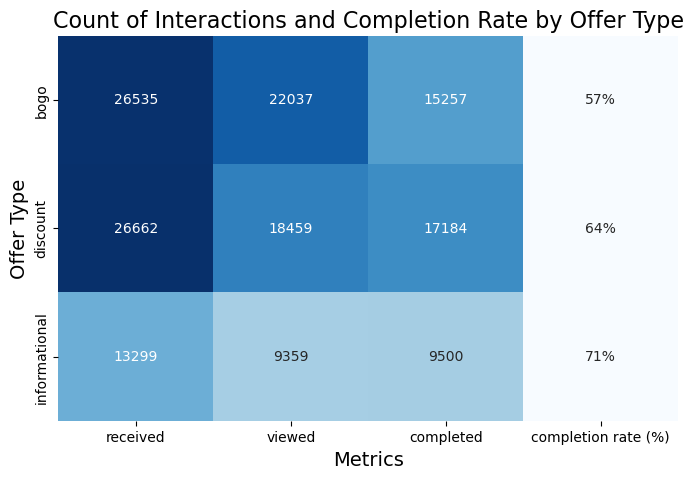

In [8]:
# Define the new label for completion_rate
column_labels = aggregated_df.columns.tolist()
column_labels = ["received", "viewed", "completed", "completion rate (%)"]  # Adjust the labels as needed

# Define a custom annotation function
def custom_annotate(data):
    # Check if the current row is 'completion_rate' to add % sign
    return data.apply(lambda x: f"{int(x)}%" if data.name == 'completion_rate' else f"{int(x)}")

# Create a formatted DataFrame for annotations
annotated_df = aggregated_df.apply(custom_annotate)

# Draw the heatmap with custom annotation
plt.figure(figsize=(8, 5))

ax = sns.heatmap(
    aggregated_df,
    annot=annotated_df,
    fmt="",
    cmap="Blues",
    cbar=False
)

# Set custom labels for the columns
ax.set_xticklabels(column_labels)

# Set x and y axis labels (titles)
plt.title('Count of Interactions and Completion Rate by Offer Type', fontsize=16)
plt.ylabel('Offer Type', fontsize=14)
plt.xlabel('Metrics', fontsize=14)

# Display plot
plt.show()


### Alternative Chart Visual

This chart visually represents **offer interactions** (received, viewed, and completed) for each offer type, as well as the **completion rate** for those offers. It combines stacked bar segments and a line plot, providing a clear overview of both the interaction counts and associated completion rates.

1. **Bar Chart**:
   - I use a **stacked bar chart** to show the total counts of interactions for each offer type.
   - The bars are divided into three segments:
     - **Received** (sky blue)
     - **Viewed** (light coral)
     - **Completed** (light green)
   - The **height of each segment** represents the total count for that interaction type (received, viewed, or completed) for each offer.
   - **Labels** with counts are placed at the center of each bar segment to provide exact values for each interaction type.

2. **Completion Rate Line**:
   - I plot a **completion rate line** using a secondary y-axis, overlaid on the bar chart.
   - The line represents the percentage of **offers completed** relative to **offers received**.
   - I annotate the completion rate along the line with rounded percentages for each offer type.

3. **Legends**:
   - I split the legend into two parts:
     - **Interactions**: The legend for the stacked bar chart is located at the top center and includes categories for the received, viewed, and completed interactions.
     - **Metrics**: The legend for the completion rate line is positioned at the top right and indicates the line's color (gray).

4. **Labels and Axes**:
   - The **X-axis** represents the different **offer types** (e.g., bogo, discount, informational).
   - The **primary y-axis** shows the **count** of interactions (received, viewed, and completed).
   - The **secondary y-axis** is used for the **completion rate**, expressed as a percentage.


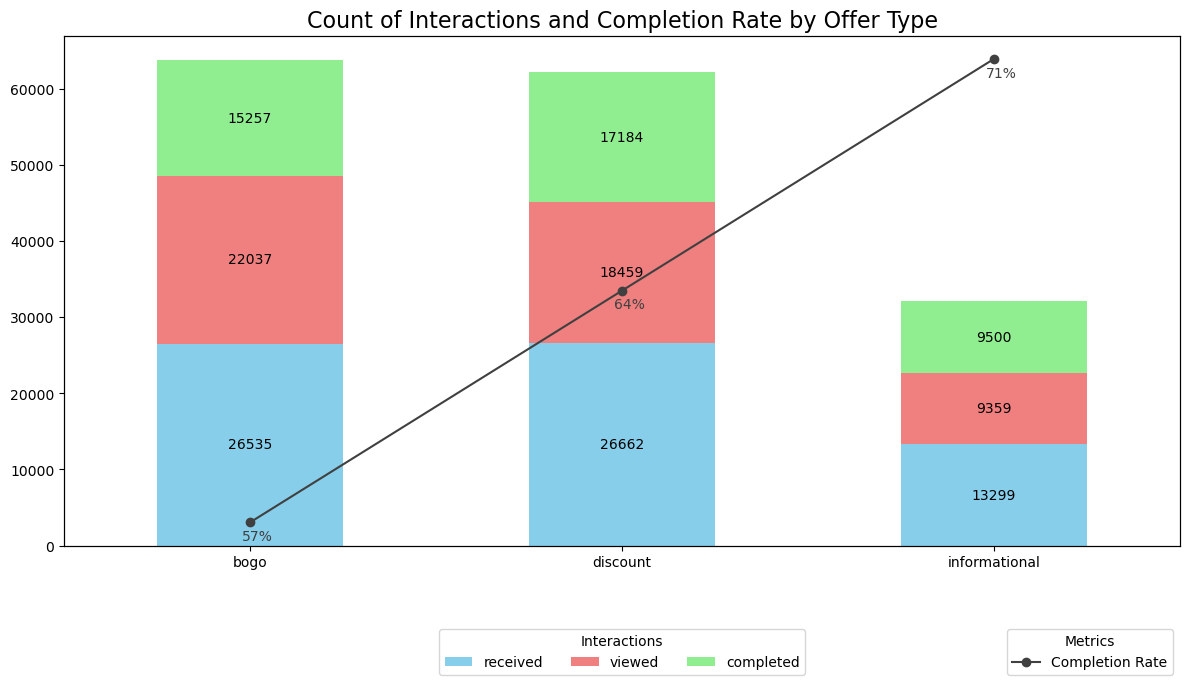

In [9]:
plt.figure(figsize=(12, 7))

# Plot the stacked bar chart for received, viewed, and completed counts
ax = aggregated_df[['received', 'viewed', 'completed']].plot(
    kind='bar', stacked=True, color=['skyblue', 'lightcoral', 'lightgreen'], ax=plt.gca()
)

# Add labels with counts on each bar segment
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center', color='black')

# Plot the completion rate line on the secondary y-axis
ax2 = ax.twinx()
ax2.plot(aggregated_df.index, aggregated_df['completion_rate'], color='#404040', marker='o', label='Completion Rate')

# Annotate the completion rate percentages without decimals
for i, val in enumerate(aggregated_df['completion_rate']):
    ax2.annotate(f'{int(val)}%', 
                 (i, val), 
                 textcoords="offset points", 
                 xytext=(5, -13),  # Move labels below the dot
                 ha='center', 
                 color='#404040')


# Hide the y-axis label and ticks for the completion rate line
ax2.get_yaxis().set_visible(False)

# Adjust the legends
# Move "Interactions" legend to the center and "Metrics" to the right, both slightly lower
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), title="Interactions", ncol=3)
ax2.legend(loc='upper right', bbox_to_anchor=(1, -0.15), title="Metrics")

# Labels and title
plt.title('Count of Interactions and Completion Rate by Offer Type', fontsize=16)
plt.xlabel('Offer Type', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set x-axis labels to be horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Display plot
plt.tight_layout()
plt.show()


### Demographic Breakdown of Offer Interactions

This section of the analysis focuses on the **demographic breakdown** of offer interactions (received, viewed, and completed) by age group for each offer type (e.g., **bogo**, **discount**, and **informational**). It provides insights into how different age groups interact with the offers.

#### Steps:

1. **Age Grouping**:
   - I create the `age_group` column by categorizing customers into specific **age bins** (18-24, 25-34, etc.). This classification allows me to analyze how different age groups interact with offers.
   
2. **Data Processing**:
   - For each **offer type**, I identify relevant columns for **received**, **viewed**, and **completed** interactions by searching for columns containing both the specific offer type and interaction type in their names.
   - I perform **data grouping** by the `age_group` column, aggregating interactions for each offer type across all age groups.
   
3. **Visualization**:
   - I create a **horizontal bar chart** for each offer type, where the **age group** is displayed on the y-axis and the **interaction counts** (received, viewed, completed) are displayed on the x-axis.
   - Each bar represents the **count of interactions** for a particular **age group** and **offer type**. The bars are color-coded:
     - **Received** interactions: sky blue
     - **Viewed** interactions: light coral
     - **Completed** interactions: light green
   - I add **labels** with the counts to each bar segment, as well as the % completed metric.
   
4. **Titles and Labels**:
   - I title the chart using the offer type (e.g., "Bogo Offers Breakdown by Age Group"), giving an understanding of which offer type is being analyzed.
   - The **x-axis** represents the **count** of interactions, and the **y-axis** shows the **age group**.

<Figure size 1200x700 with 0 Axes>

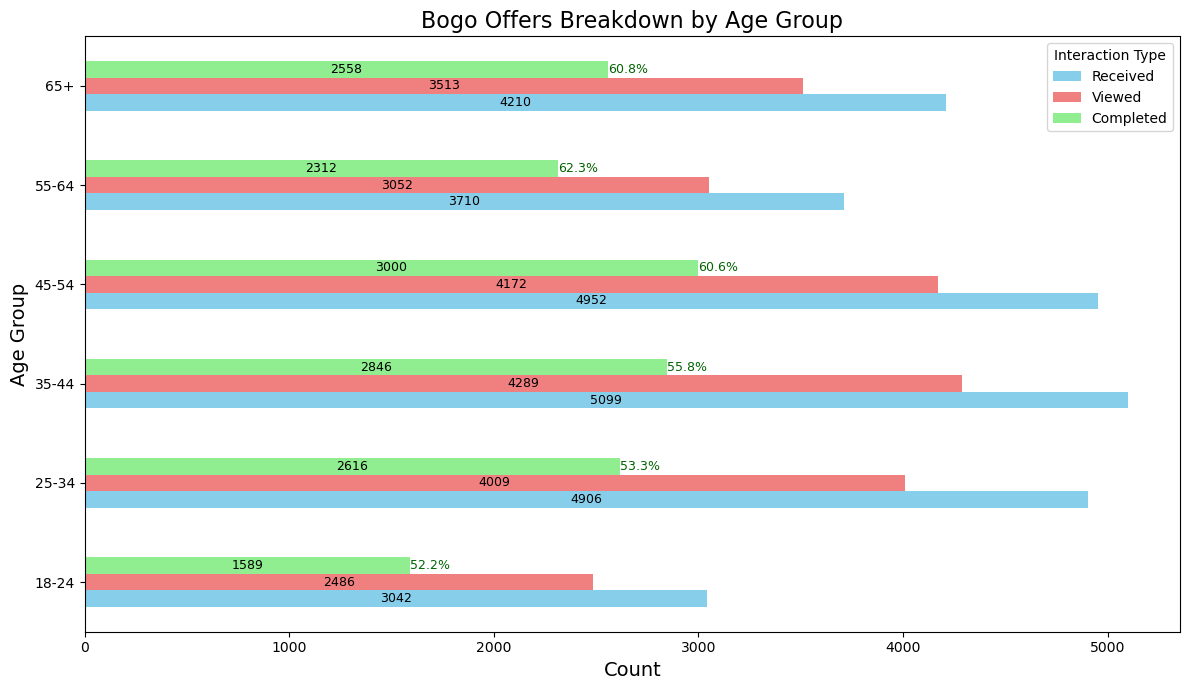

<Figure size 1200x700 with 0 Axes>

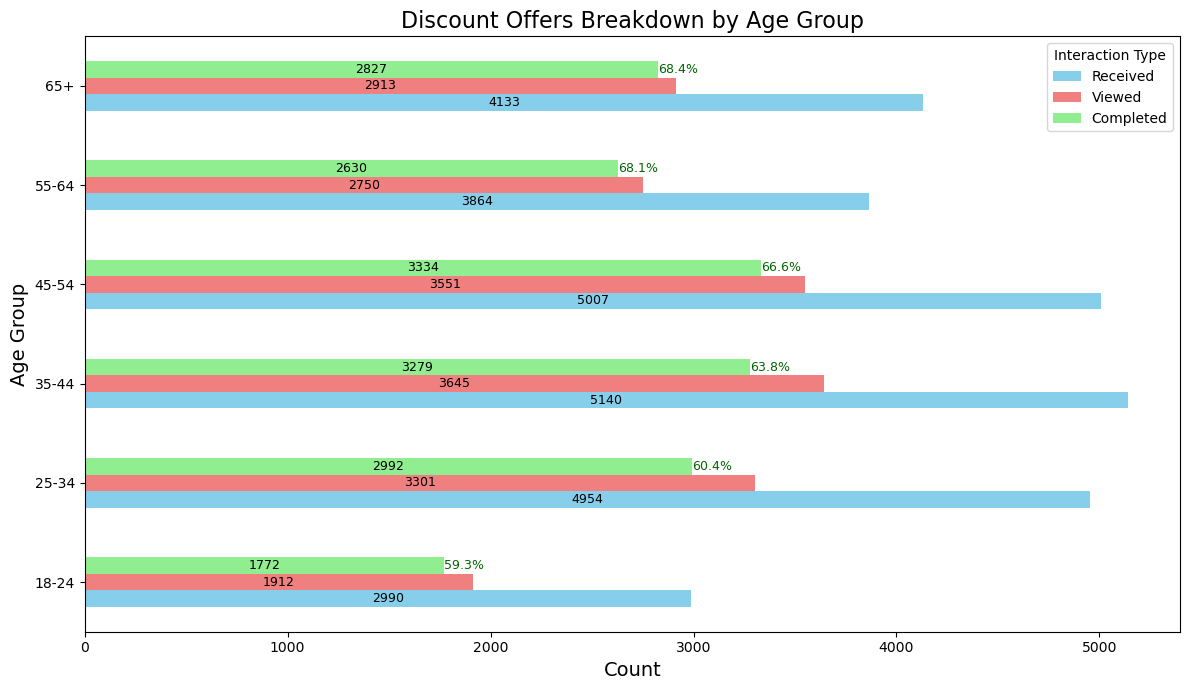

<Figure size 1200x700 with 0 Axes>

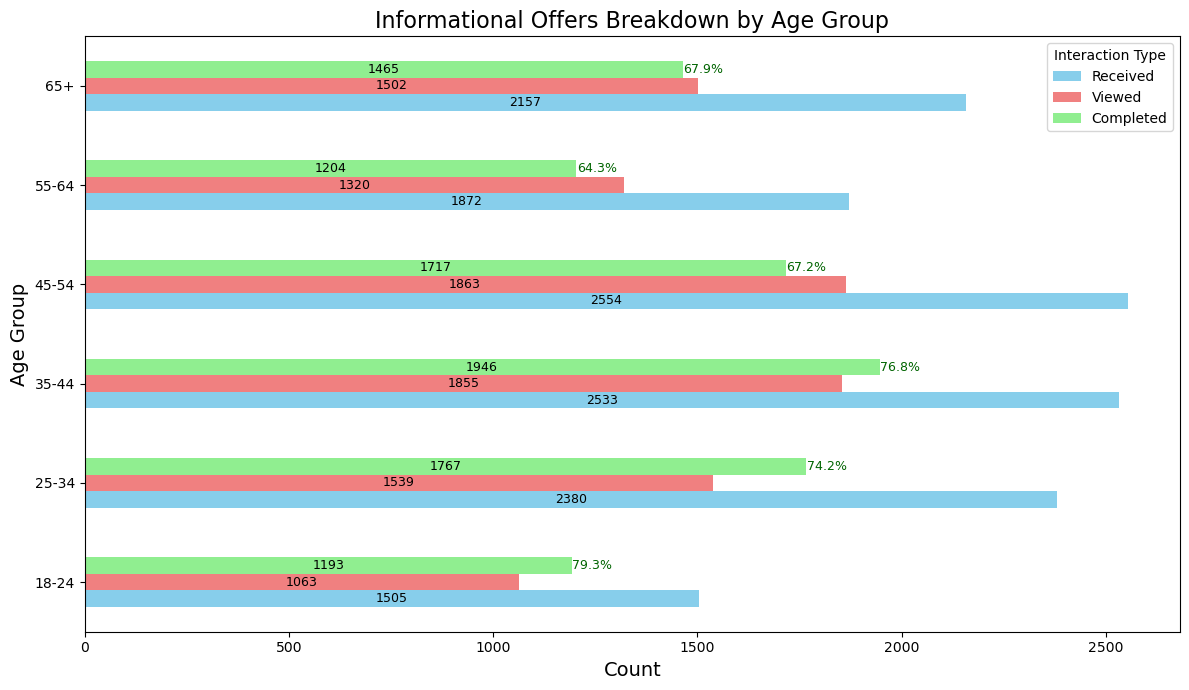

In [11]:
# Create age bins
bins = [18, 24, 34, 44, 54, 64, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
customers['age_group'] = pd.cut(customers['age'], bins=bins, labels=labels, right=True)

# Helper function to create the demographic breakdown chart
def plot_demographic_breakdown(offer_type):
    # Identify relevant columns for the current offer type (received, viewed, completed)
    received_columns = [col for col in customers.columns if offer_type in col and 'received' in col]
    viewed_columns = [col for col in customers.columns if offer_type in col and 'viewed' in col]
    completed_columns = [col for col in customers.columns if offer_type in col and 'completed' in col]

    # Group by age and sum the counts for each offer type (received, viewed, completed)
    received_by_age = customers.groupby('age_group', observed=False)[received_columns].sum().sum(axis=1)
    viewed_by_age = customers.groupby('age_group', observed=False)[viewed_columns].sum().sum(axis=1)
    completed_by_age = customers.groupby('age_group', observed=False)[completed_columns].sum().sum(axis=1)

    # Calculate the completion rate for each age group
    completion_rate = (completed_by_age / received_by_age * 100).fillna(0)

    # Combine the data into a DataFrame for plotting
    demographic_df = pd.DataFrame({
        'Received': received_by_age,
        'Viewed': viewed_by_age,
        'Completed': completed_by_age
    })

    # Plotting the data
    plt.figure(figsize=(12, 7))
    ax = demographic_df[['Received', 'Viewed', 'Completed']].plot(
        kind='barh', 
        stacked=False, 
        color=['skyblue', 'lightcoral', 'lightgreen'],
        figsize=(12, 7)
    )
    
    # Annotate count labels for all bars
    for bar in ax.patches:
        width = bar.get_width()
        height = bar.get_height()
        x, y = bar.get_xy()
        # Add the count value inside each bar
        plt.text(x + width / 2, y + height / 2, f'{int(width)}', ha='center', va='center', fontsize=9, color='black')

    # Annotate percentages (completion rate) next to the "Completed" bars
    for idx, bar in enumerate(ax.patches[-len(completed_by_age):]):  # Only annotate the "Completed" bars
        x = bar.get_x() + bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        plt.text(x + 0.5, y, f'{completion_rate.iloc[idx]:.1f}%', va='center', fontsize=9, color='darkgreen')

    # Add labels and title
    plt.title(f'{offer_type.capitalize()} Offers Breakdown by Age Group', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Age Group', fontsize=14)
    plt.legend(title='Interaction Type')
    plt.tight_layout()
    plt.show()

# Loop through the offer types and create the breakdown for each one
for offer_type in offer_type_mapping:
    plot_demographic_breakdown(offer_type)


## Executive Summary

Key findings include:
- A campaign-wide completion rate of ~63%.
- Informational offers showed both extreme successes (93% completion for one campaign) and weaknesses (50% completion for another).
- The success of informational offers suggests significant customer interest, but the lack of transaction-level data makes it difficult to gauge their true impact.
- Demographic trends reveal younger customers are least engaged overall, while older customers show high engagement with discount and BOGO offers.
- Older customers are consistently more engaged across most offer types.
- Younger customers engage more with informational offers but represent the smallest proportion of customers.


### Completion Rates

- **Total Interactions**: 66,496 offers were received, and 41,941 were completed (~63% completion rate).
- **Informational Offers**:
  - Informational_2 excelled with a 93% completion rate.
  - Informational_1 performed poorly, with a 50% completion rate.
  - Informational offers have a short 3-day window for completion, therefore their long-term impact on purchases can't be reliably measured. Customers may interact with these campaigns beyond the 3-day window.
- **Discount Offers**: 
  - Discount_3 achieved the highest success at 75% completion.
  - Discount_1 was weaker at 50%.
- **BOGO Offers**:
  - These had the overall lowest completion rate (57%), with Bogo_2 standing out as particularly weak.

### Customer Demographics

1. **BOGO Offers**:
   - Weakest engagement in the 18–34 age group.
   - Best performance with customers aged 55–64.
   - Most completions came from the 45–54 age group.
2. **Discount Offers**:
   - Lowest engagement from customers under 34.
   - High and consistent redemption rates from customers aged 45 and older.
3. **Informational Offers**:
   - Highest completion rates in customers aged 18–34.
   - The 45–54 age group completed the most offers numerically.


## Recommendations

1. **Informational Offers**:
   - Consider capturing transaction-level data to verify their true impact.
   - Investigate why Informational_2 was so successful and replicate its elements in future campaigns.

2. **BOGO Offers**:
   - Reassess the products included in these campaigns. They may not align with customer preferences.
   - Test alternative product selections or incentives on a small scale, borrowing successful elements from discount and informational campaigns.
   - Examine other factors such as redemption time limits, minimum spend thresholds, and marketing channels.

3. **Demographics**:
   - Increase outreach to the 18–34 demographic, who represent the smallest customer base but are responsive to informational offers.
   - Incorporate products and patterns from successful informational campaigns into BOGO and discount offers.
   - Explore whether income levels or other demographic traits influence engagement and how.